In [5]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'arial',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)

import seaborn as sns
from scipy.stats import kde
import pandas as pd

import random
from shephard.apis import uniprot, fasta

In [7]:
import shephard
from shephard.interfaces import si_protein_attributes, si_domains, si_sites




### How to use
The cell below must be updated to point a local directory where the [SHEPHARD data from Ginell et al. has been downloaded from](https://github.com/holehouse-lab/supportingdata/tree/master/2022/ginell_2022/shprd_data)

In [ ]:

# link to the directory at https://github.com/holehouse-lab/supportingdata/tree/master/2022/ginell_2022/shprd_data
shephard_data_dir = '<base_dir> 2022/ginell_2022/shprd_data/'

In [19]:
# ---------------------------------------------------------------
#
def count_unique_phosphosites(site_list):
    """
    Function that takes a list of SHEPHARD sites and returns the 
    number of unique positions that are phosphorylated.
    
    Parameters
    ---------------
    site_list : list
        Lits of shephard.Site objects 
    
    
    Returns
    ---------------
    int
        Returns the number of unique sites in the list of sites
        
    """
    
    found = set([])

    for site in site_list:
        if site.site_type in ['Phosphoserine', 'Phosphothreonine', 'Phosphotyrosine']:
            found.add(site.position)
            
    return len(found)


# ---------------------------------------------------------------
#
def get_average_phos_den(uid_list, human_proteome):
    """
    Function which, given a list of Uniprot IDs and a Proteome
    object, returns the average number of sites that are phosphorylated
    given those uniprot IDs.
    
    Parameters
    --------------
    uid_list : list
        A list of unique IDs that will be scanned in the shephard.Proteome
        object
        
    human_proteine : shephard.Proteome
        A proteome object 
        
        
    Return
    --------------
    float
        Returns the average phosphosite density across all the proteins
        in the the list of unique IDs.
    """
    
    # initialized empty list
    phos_den = []
    
    # cycle over the passed unique IDs
    for uid in uid_list:
        
        # grab a protein
        prot = human_proteome.protein(uid)
        
        # get the number of unique sites that get phosphorylated
        p = count_unique_phosphosites(prot.sites)
        
        # calculate the denisty (number of unique phosphosites/)
        phos_den.append(p/len(prot))
        
    return np.mean(phos_den)


In [8]:

# load the human proteome 
human_proteome = uniprot.uniprot_fasta_to_proteome(f'{shephard_data_dir}/human_proteome_validated.fasta')

# annotate the human proteome with phosphosites
si_sites.add_sites_from_file(human_proteome, f'{shephard_data_dir}/shprd_sites_filtered_proteomescout.tsv')


        


In [17]:
# manual list of the proteins identified as abundant, highly charged, and not
# part of some consitutive cellular body (membrane, chromatin, ribosome, RNP)
non_membrane_hist_ribo = ['P53999','Q07955','P84103','P21291','P50461','Q16629','Q99848','Q9Y2T7','P62995','Q86V81','Q01130','P50238','O75526','P38159','Q14498','Q15287','O76021','Q9NY12','Q8TDN6','Q9NX58','Q9Y3C1','Q9Y2W1','Q9Y4Z0','Q9BQ69']

# calculate the average phosposite density for those proteins
real_data = get_average_phos_den(non_membrane_hist_ribo)    


print(f"Mean fraction of phosphosites: {round(real_data,3)}")



Mean fraction of phosphosites: 0.094


In [20]:
# This cycle 
#
#

# get all the unique IDs into a list
all_uid = [prot.unique_ID for prot in human_proteome]

# initailize the empty list
random_means = []

# number of random permutations
number_selects = 5000

# defines the size of subsets we're going to select
pool_size = len(non_membrane_hist_ribo)

# cycle over $number_selects times
for x in range(number_selects):
    
    # randomly shuffle the list of uniprot IDs
    random.shuffle(all_uid)
    
    # grab the first $poll_size unique IDs
    random_uid = all_uid[0:pool_size]
    
    # for those IDs calculate the average phophosite density
    random_means.append(get_average_phos_den(random_uid, human_proteome))
    

4.733827955552872


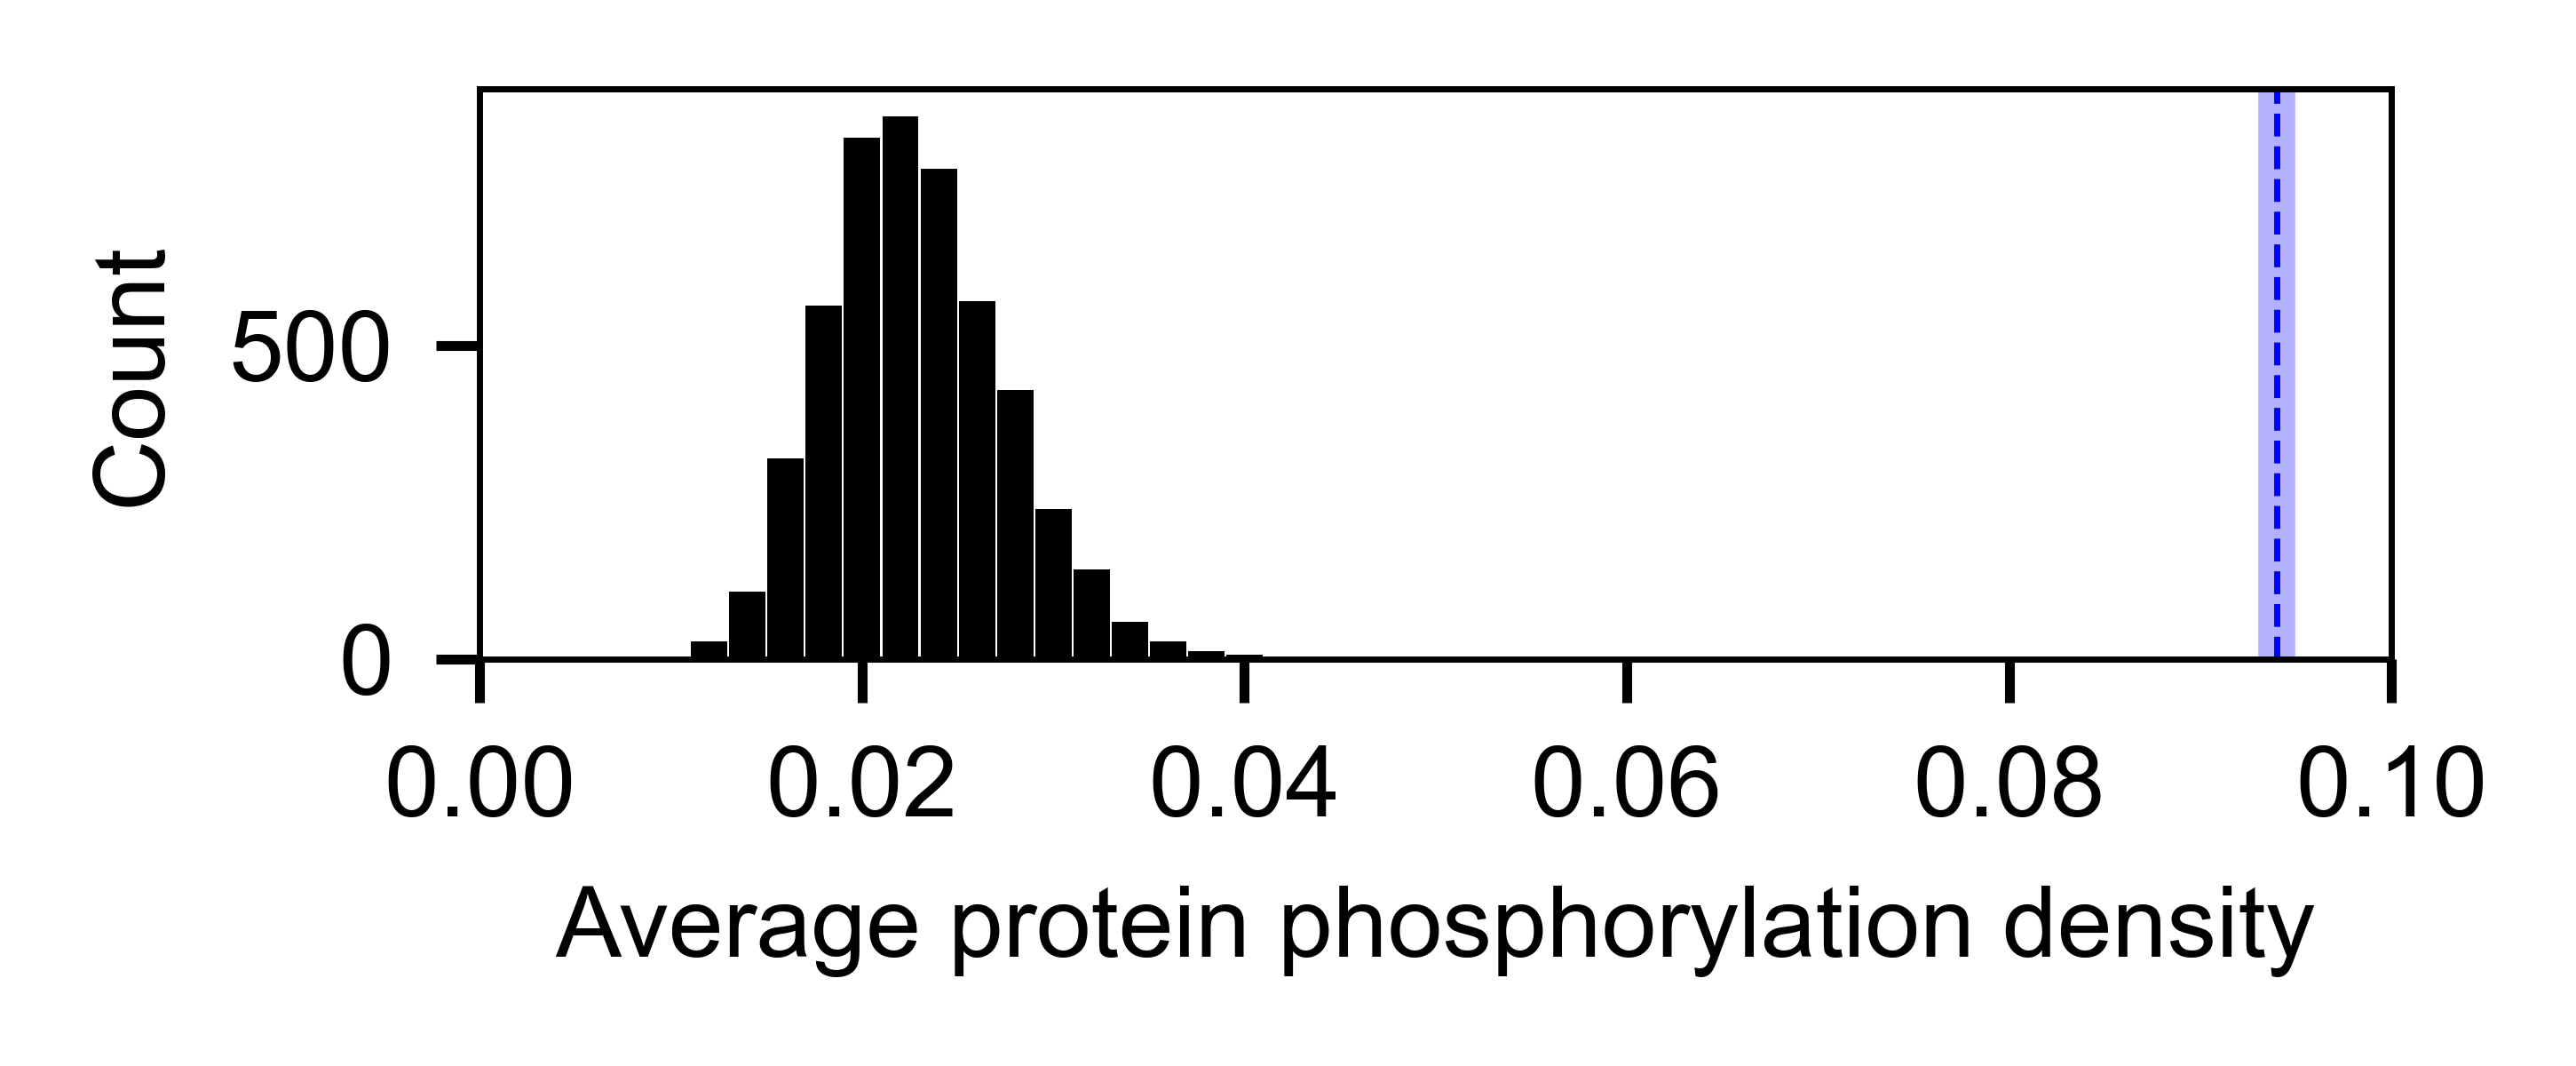

In [21]:
# Finally generate a figure
#
#

figure(num=None, figsize=(3,1.3), dpi=500, facecolor='w', edgecolor='k')

bin_width = 0.002
bins = np.arange(0,0.15, bin_width)
[a,b] = np.histogram(random_means, bins=bins)
real_bins = bins[1:]+bin_width
plt.bar(real_bins,a, width=bin_width*0.95, color='k')
ax = plt.gca()
ax.axvline(real_data, linestyle='-',color='b', linewidth=3, alpha=0.3)
ax.axvline(real_data, linestyle='--',color='b', linewidth=0.5)

plt.xlim([0,0.1])
print(real_data/np.mean(random_means))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xlabel('Average protein phosphorylation density', fontsize=8)
plt.tight_layout()
plt.savefig('positive_protein_phosphoenrichment.pdf')